### This Script Plots the Ablation Curves

import relevant Libraries

In [ ]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

In [3]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Legend
from bokeh.palettes import Category10
from bokeh.plotting import figure, output_file, save

# Set WD
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

### Load Data

In [6]:
# Load Unique Stations
station_list = pd.read_csv('data/promice/stations.csv')

In [7]:
# This bit to define the data that is to be loaded
import glob

# Define the directory path where the CSV files are located
input_path = 'data/promice/preprocessed/daily/'

# Define a pattern to match the filenames of the CSV files
pattern = '*.csv'

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)

In [9]:
dfs = []
for file in filenames:
    df = pd.read_csv(file, index_col=False)
    dfs.append(df)
df = pd.concat(dfs)

## Print Function

In [6]:
def plt_srf_height(Station, input_df=df, y=df['Surface height from combined measurements'], Period="All"):
    df = input_df[input_df['stid'] == Station].copy()

    if Period != "All":
        start_date = Period[0]
        end_date = Period[1]
        df = df[df['Datetime'].between(start_date, end_date)]
        
    # Define the colors for the melting season categories
    colors = {'pre': 'grey', '': 'black', 'beginning': 'green', 'middle': 'orange', 'end': 'red'}
    categories = ['pre', '', 'beginning', 'middle', 'end']
    Y_name = y.name
    
    # Define the x-axis and y-axis values
    x = df['Datetime'].values
    y = y.fillna(-999).values
    
    if -999 in y:
        y_without_neg999 = [val for val in y if val != -999]
        minimum = min(y_without_neg999)
    else:
        minimum = min(y)

    data = {}
    for i, category in enumerate(categories):
        # Get the indices where the Melting Season column matches the current category
        indices = df[df['Melting Season'] == category].index
        
        # Create a ColumnDataSource for the current category
        source = ColumnDataSource({'x': x[indices], 'y': y[indices]})
        data[category] = source.data
    
    # Create a figure
    fig = figure(title=Station + " " , x_axis_label='Date', y_axis_label= Y_name, 
                 x_axis_type='datetime', width=1200, height=500,y_range=(minimum, max(y) + 2))

    # Iterate over the melting season categories and add a scatter plot for each category
    for i, category in enumerate(categories):
        fig.scatter('x', 'y', source=data[category], color=colors[category], alpha=0.7, 
                    legend_label=category, size=4)
    
    # Shade areas with "Ablation" = True
    ablation_mask = df["Ablation"]
    ablation_starts = df["Datetime"][ablation_mask & ~ablation_mask.shift(1, fill_value=False)]
    ablation_ends = df["Datetime"][ablation_mask & ~ablation_mask.shift(-1, fill_value=False)]
    for start, end in zip(ablation_starts, ablation_ends):
        fig.patch([start, end, end, start], [minimum, minimum, max(y), max(y)], fill_color='yellow', alpha=0.2, line_color=None)
    
    # Add a legend to the plot
    fig.legend.location = 'top_right'
    fig.legend.title = 'Melting Season'
    fig.legend.title_text_font_size = '14pt'
    fig.legend.label_text_font_size = '12pt'
    fig.legend.click_policy = 'hide'

    # Show the plot
    show(fig)
    

## All Stations

In [ ]:
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

df["year"] = df["Datetime"].dt.year
df["month"] = df["Datetime"].dt.month
df['Melting Season'] = df['Melting Season'].fillna('')

## KAN_L / SCO_L Daily

In [5]:
os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')
df = pd.read_csv('data/promice/preprocessed/daily/SCO_L.csv')

##### Missing values overview

In [7]:
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

df["year"] = df["Datetime"].dt.year
df["month"] = df["Datetime"].dt.month
df['Melting Season'] = df['Melting Season'].fillna('')

x = df[df['Melting Season'] != '']
x = df[df['Ablation'] == True]

# Calculate the total number of missing values by year and month
missing_values = x.isna().groupby([x['year'], x['month']]).sum()

# Only keep rows with missing values in at least one column
missing_values = missing_values[missing_values.sum(axis=1) > 0]

# Add a Total NA column and Total Count column
missing_values["Total NA"] = missing_values.sum(axis=1)

# Transpose the missing values dataframe
missing_values = missing_values.transpose()

# Calculate the percentage of rows to exclude by Melting Season group
rows_to_exclude = x[x.isna().any(axis=1)].groupby(["Melting Season"])["Datetime"].count() / df.groupby(["Melting Season"])["Datetime"].count() * 100

# Print the results
missing_values


year                                            2008           2009            \
month                                              7    8    9    6    7    8   
Unnamed: 0                                         0    0    0    0    0    0   
stid                                               0    0    0    0    0    0   
Datetime                                           0    0    0    0    0    0   
Air pressure (upper boom)                          0    0    0    0    0    0   
Air temperature (upper boom)                       0    0    0    0    0    0   
Relative humidity (upper boom) - corrected         0    0    0    0    0    0   
Specific humidity (upper boom)                     0    0    0    0    0    0   
Wind speed (upper boom)                           10   31   24   29   31   31   
Wind from direction (upper boom)                  10   31   24   29   31   31   
Downwelling shortwave radiation - corrected        0    0    0    0    0    0   
Upwelling shortwave radiation - corrected          0    0    0    0    0    0   
Downwelling longwave radiation                     0    0    0    0    0    0   
Upwelling longwave radiation                       0    0    0    0    0    0   
Surface temperature                                0    0    0    0    0    0   
Latent heat flux (upper boom)                     10   31   24   29   31   31   
Sensible heat flux (upper boom)                   10   31   24   29   31   31   
Surface height from combined measurements          0    0    0    0    0    0   
Surface height from combined measurements DELTA    0    0    0    0    0    0   
Albedo                                             0    0    8    0    0    0   
Cloud cover                                        0    0    0    0    0    0   
Ablation                                           0    0    0    0    0    0   
Melting Season                                     0    0    0    0    0    0   
year                                               0    0    0    0    0    0   
month                                              0    0    0    0    0    0   
Total NA                                          40  124  104  116  124  124   

year                                                2010           2013 2014  \
month                                             9    6    7    9    9    9   
Unnamed: 0                                        0    0    0    0    0    0   
stid                                              0    0    0    0    0    0   
Datetime                                          0    0    0    0    0    0   
Air pressure (upper boom)                         0    0    0   12    0    0   
Air temperature (upper boom)                      0    0    0   12    0    0   
Relative humidity (upper boom) - corrected        0    0    0   12    0    0   
Specific humidity (upper boom)                    0    0    0   12    0    0   
Wind speed (upper boom)                          12   28   25   12    0    0   
Wind from direction (upper boom)                 12   28   25   12    0    0   
Downwelling shortwave radiation - corrected       0    0    0   12    0    0   
Upwelling shortwave radiation - corrected         0    0    0   12    0    0   
Downwelling longwave radiation                    0    0    0   12    0    0   
Upwelling longwave radiation                      0    0    0   12    0    0   
Surface temperature                               0    0    0   12    0    0   
Latent heat flux (upper boom)                    12   28   25   12    0    0   
Sensible heat flux (upper boom)                  12   28   25   12    0    0   
Surface height from combined measurements         0    0    0    0    0    0   
Surface height from combined measurements DELTA   0    0    0    0    0    0   
Albedo                                            0    0    0   12    4   10   
Cloud cover                                       0    0    0   12    0    0   
Ablation                                          0 

In [14]:
df.groupby(["Melting Season"]).count().Datetime

Melting Season
             2088
beginning     228
end           234
middle       1007
pre          1752
Name: Datetime, dtype: int64

In [15]:
xx = df.dropna()
xx.groupby(["Melting Season"]).count().Datetime

Melting Season
              50
beginning    186
end          163
middle       855
pre          802
Name: Datetime, dtype: int64

##### Plotting

In [9]:
fig = plt_srf_height(Station = "SCO_L", input_df = df, y = df['Surface height from combined measurements DELTA']) 



In [ ]:

output_file("figures/KAN_L/KAN_L_delta.html")
save(fig)

--------

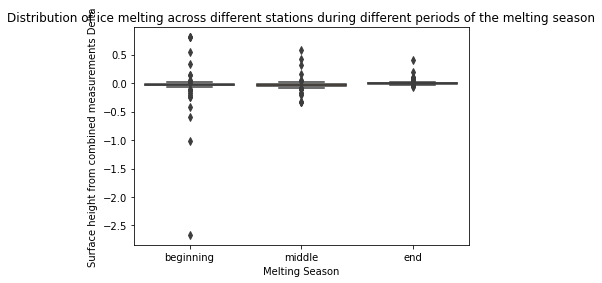

In [46]:
import seaborn as sns

# filter the dataframe to only include rows where ablation occurred
ablation_df = df[df['Ablation'] == True]

# create a box plot for each melting season category
sns.boxplot(x='Melting Season', y='Surface height from combined measurements DELTA', data=ablation_df)

# add labels and title to the plot
plt.xlabel('Melting Season')
plt.ylabel('Surface height from combined measurements Delta')
plt.title('Distribution of ice melting across different stations during different periods of the melting season')
plt.show()

KeyError: 'Melting Season begin'

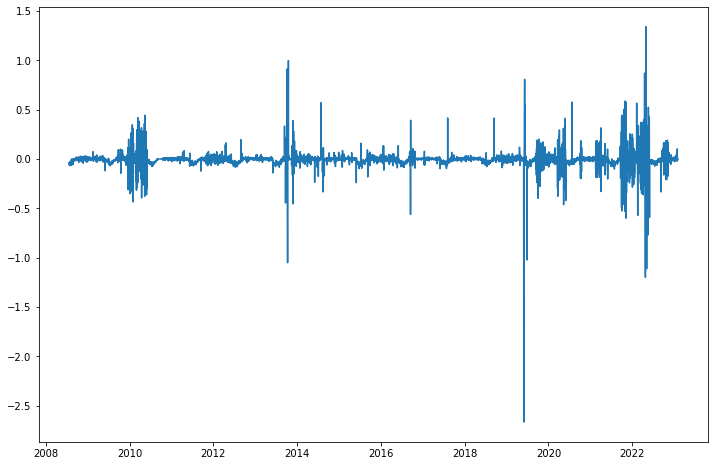

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# filter the dataframe to only include rows where ablation occurred
ablation_df = df[df['Ablation'] == True]

# create a line plot for each station, highlighting the periods of ablation
fig, ax = plt.subplots(figsize=(12,8))

for stid in ablation_df['stid'].unique():
    station_df = df[df['stid'] == stid]
    ax.plot(station_df['Datetime'], station_df['Surface height from combined measurements DELTA'], label=stid)
    for _, row in ablation_df[ablation_df['stid'] == stid].iterrows():
        ax.axvspan(row['Melting Season begin'], row['Melting Season end'], alpha=0.2, color='orange')
        ax.axvline(row['Melting Season begin'], color='orange', linestyle='--')
        ax.axvline(row['Melting Season end'], color='orange', linestyle='--')

# set plot title, axis labels and legend
ax.set_title('Surface height from combined measurements Delta during ablation periods')
ax.set_xlabel('Date')
ax.set_ylabel('Surface height from combined measurements Delta')
ax.legend()

plt.show()
